# Banknote Authentication via Least Squares

> *Numerical Optimization and Large Scale Linear Algebra*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

Your aim is to predict whether a given banknote is authentic given a number of measures. Using the **least square** procedure create a classifier. Then, create the confusion matrix for the training set. If the logical assumption "If the prediction value > $0.5$, then classify the item as $1$, otherwise as $0$." leads to serious unbalancing number of false negative and false positive responses, try to find - heuristically - a value that balance the two numbers. For this threshold, run your model for the test set. Give the confusion matrix for the test set, and the error rates for the 2 sets. Finally, follow any appropriate transformation technique and try to increase the accuracy of the model.

---

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import math
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler

## Data

In [2]:
#train set
train_notes = pd.read_csv('./Data/train_backnotes.csv', sep = ',')
train_notes = train_notes.iloc[:,1:6]

#test set
test_notes = pd.read_csv('./Data/test_backnotes.csv', sep = ',')

#labels of the test set are in another file
test_out = pd.read_csv('./Data/test_backnotes_l.csv', sep = ',')
test_notes = test_notes.iloc[:,1:6]
test_notes['output'] = test_out['output']

#preview train set
train_notes.head()

,variance,skewness,kurtosis,entropy,output
0,1.1472,3.59850,1.9387,-0.43406,0
1,-1.7322,-9.28280,7.7190,-1.71680,1
2,-1.1022,-5.83950,4.5641,0.68705,1
3,-1.7063,2.79560,-2.3780,-2.34910,1
4,4.8265,0.80287,1.6371,1.18750,0


In [7]:
# conversion of training and test sets to numpy arrays

X_train = train_notes.iloc[:,0:4].to_numpy()
y_train = train_notes['output'].to_numpy()

X_test = test_notes.iloc[:,0:4].to_numpy()
y_test = test_notes['output'].to_numpy()

## Least Squares Classifier

##### *Define functions to get the thetas and define the LS Classifier*

In [8]:
def thetas(x, y):
    # Add a column of ones to the input matrix x (design matrix)
    X_new = np.insert(x, 0, np.ones(len(x)), axis=1)
    
    # Perform QR factorization on the augmented design matrix X_new
    q, r = np.linalg.qr(X_new)
    
    # Compute the transpose of q multiplied by y
    p = np.dot(q.T, y)
    
    # Solve for the coefficients using the equation: coefficients = inverse(r) * p
    coef = np.dot(np.linalg.inv(r), p)
    
    return coef

In [9]:
def LeastSquaresClassiffier(X,a,coef):
    return 1 if coef[0] + coef[1]*X[0] + coef[2]*X[1] + coef[3]*X[2] + coef[4]*X[3] > a else 0

In [10]:
#get thetas
LS_Thetas = thetas(X_train, y_train)

#get predictions
train_preds = [LeastSquaresClassiffier(x, 0.5, LS_Thetas) for x in X_train]

#### *Confusion Matrix* 

##### *Define a function to plot a confusion matrix with the results of the least square classifier*

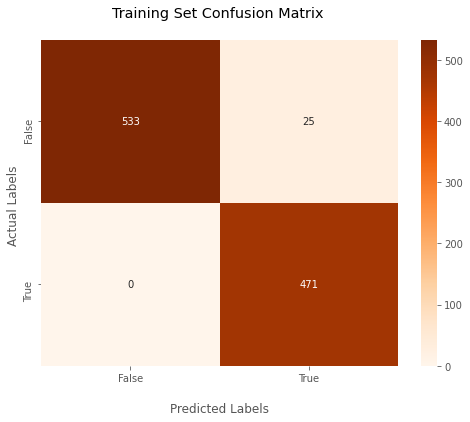

In [11]:
# function to plot confusion matrix
def plot_confusion_matrix(y_true, y_preds, title):
    
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(confusion_matrix(y_true, y_preds), annot=True, cmap='Oranges',fmt='g')

    ax.set_title(title + ' Confusion Matrix \n');
    ax.set_xlabel('\nPredicted Labels')
    ax.set_ylabel('Actual Labels ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    
    return

# execution
_ = plot_confusion_matrix(y_train, train_preds, 'Training Set')

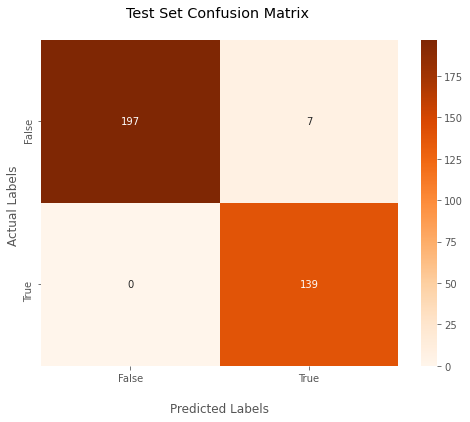

In [12]:
#get test predictions
test_preds = [LeastSquaresClassiffier(x, 0.5, LS_Thetas) for x in X_test]

# confusion matrix
_ = plot_confusion_matrix(y_test, test_preds, 'Test Set')

##### *Calculating the Error Rates of both the training and test sets*

In [13]:
print("Training Set Error Rate: {:.4f}" .format(1 - accuracy_score(y_train, train_preds)))
print("Test Set Error Rate: {:.4f}" .format(1 - accuracy_score(y_test, test_preds)))

Training Set Error Rate: 0.0243
Test Set Error Rate: 0.0204


- Examining the confusion matrix reveals a significant imbalance between false negative and false positive predictions.
- Hence, our objective is to identify a value for $\alpha$ through a *heuristic* approach that brings a balance between these two figures.

### *Fine Tuning Alpha*

##### *Define functions to find the optimal value of $α$*

We will calculate the True Positive, False Positive and False Negative rates along with the Total Error for 1000 different values of $\alpha$ in the range of (-2,2)

In [14]:
def calculate_rates(matrix):
    # Extract values from the confusion matrix
    TN, FN = matrix[0, 0], matrix[1, 0]
    TP, FP = matrix[1, 1], matrix[0, 1]

    # Calculate rates based on the confusion matrix
    TP_rate = TP / (TP + FN)
    FP_rate = FP / (FP + TN)
    FN_rate = FN / (FN + TP)

    return TP_rate, FP_rate, FN_rate

def calculate_rates_for_alpha(X_train, y_train, alpha):
    # Generate predictions for the given alpha value
    tr_preds_tune = [LeastSquaresClassiffier(x, alpha, LS_Thetas) for x in X_train]
    # Calculate confusion matrix and rates
    matrix = confusion_matrix(y_train, tr_preds_tune)
    return matrix, tr_preds_tune  # Return both the matrix and predictions

def analyze_alpha_values(X_train, y_train, alpha_values):
    # Lists to store rates and errors for each alpha value
    TP_rates = []
    FP_rates = []
    FN_rates = []
    Total_errors = []

    # Iterate over alpha values
    for alpha in alpha_values:
        # Calculate rates for the current alpha value
        matrix, tr_preds_tune = calculate_rates_for_alpha(X_train, y_train, alpha)

        # Append rates to the lists
        TP_rate, FP_rate, FN_rate = calculate_rates(matrix)
        TP_rates.append(TP_rate)
        FP_rates.append(FP_rate)
        FN_rates.append(FN_rate)
        Total_errors.append(1 - accuracy_score(y_train, tr_preds_tune))

    return TP_rates, FP_rates, FN_rates, Total_errors

# Usage
a_values = np.linspace(-2, 2, 1000)
TP_rates, FP_rates, FN_rates, Total_errors = analyze_alpha_values(X_train, y_train, a_values)

##### *We will plot the rates for the different values of the threshold $\alpha$*

The optimal value is a the intersection of these lines

Text(0.5, 0, 'Values of Threshold a')

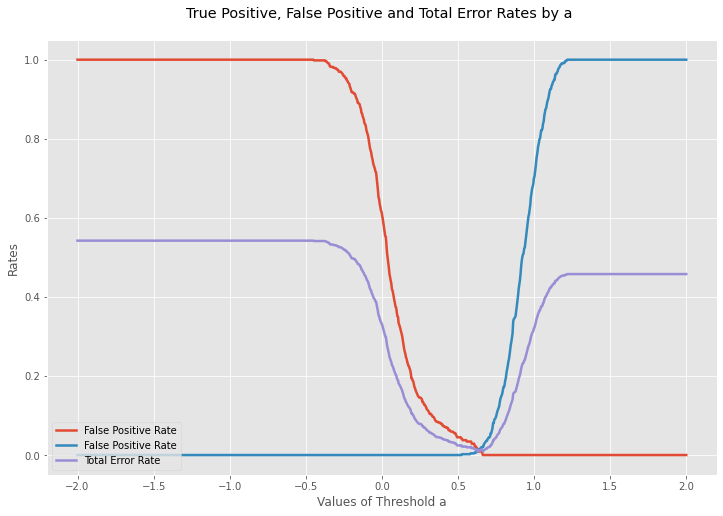

In [15]:
plt.figure(figsize=(12,8))

plt.plot(a_values,FP_rates, linewidth = 2.5)
plt.plot(a_values,FN_rates, linewidth = 2.5)
plt.plot(a_values,Total_errors, linewidth = 2.5)

plt.legend(['False Positive Rate','False Positive Rate','Total Error Rate'], loc = 'lower left')
plt.title("True Positive, False Positive and Total Error Rates by a \n")
plt.ylabel("Rates")
plt.xlabel("Values of Threshold a")

##### *We will define a function to calculate the optimal value of the threshold $\alpha$*

In [16]:
def find_optimal(FP_Rate, FN_Rate, alphas):
    
    diff = 100
    
    for i in range (len(alphas)):
    
        if (abs(FN_Rate[i] - FP_Rate[i]) < diff):
            diff = abs(FN_Rate[i] - FP_Rate[i])
            optimal_alpha = alphas[i]
    
    print(f'The minimum difference between FP and FN is {diff}.', end='\n\n')
    print(f'The best value of alpha is {round(optimal_alpha,5)}.')
    
    return optimal_alpha

In [17]:
optimal_alpha = find_optimal(FP_rates, FN_rates, a_values)

The minimum difference between FP and FN is 0.0004680044745793664.

The best value of alpha is 0.63063.


#### *Confusion Matrix with tuned alpha* 

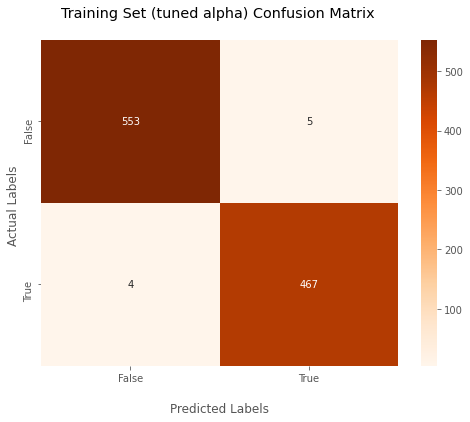

In [18]:
#get train set predictions
tuned_train_preds = [LeastSquaresClassiffier(x, optimal_alpha, LS_Thetas) for x in X_train]

# confusion matrix
_ = plot_confusion_matrix(y_train, tuned_train_preds, 'Training Set (tuned alpha)')

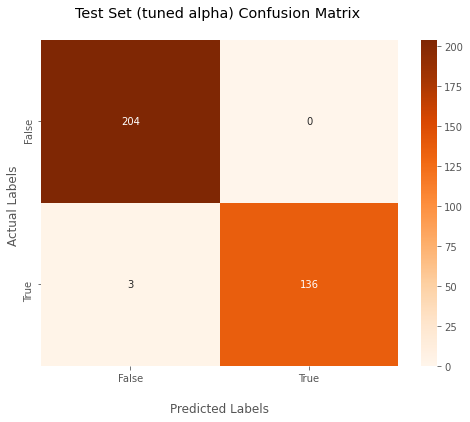

In [19]:
#get train set predictions
tuned_test_preds = [LeastSquaresClassiffier(x, optimal_alpha, LS_Thetas) for x in X_test]

# confusion matrix
_ = plot_confusion_matrix(y_test, tuned_test_preds, 'Test Set (tuned alpha)')

##### *Error Rates*

In [46]:
print("Training Set (tuned alpha) Error Rate: {:.5f}" .format(1 - accuracy_score(y_train, tuned_train_preds)))
print("Test Set (tuned alpha) Error Rate: {:.5f}" .format(1 - accuracy_score(y_test, tuned_test_preds)))

Training Set (tuned alpha) Error Rate: 0.00875
Test Set (tuned alpha) Error Rate: 0.00875


##### *Comments*

- As we can see we have managed to improve the balance between the **False Positive** and **False Negative** rates 
- This also leads to a better performing classifier, which is evident from the both error rates